# k Nearest Neighbors and Model Evaluation

In [1]:
import random
from typing import List, Dict, Tuple, Callable, Any
import math
from matplotlib import pyplot as plt
import copy
import statistics as stats

## Problem Overview

Use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete using the `concrete_compressive_strength.csv` file in the `Datasets` directory. 

Use Mean Square Error as the evaluation metric.

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

## Load the Data

<a id="parse_data"></a>
### parse_data

*The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation.*

* **file_name** str: the name of the file to load

**returns** List[List].

In [2]:
## function provided by S. Butcher, 2022
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [3]:
data = parse_data("Datasets/concrete_compressive_strength.csv")

In [4]:
data[0]

[295.7, 0.0, 95.6, 171.5, 8.9, 955.1, 859.2, 3.0, 22.95]

In [5]:
len(data)

1030

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

## Train/Test Splits - n folds

<a id="create_folds"></a>
### create_folds

*The function `create_folds` takes a list (xs) and splits it into `n` equal folds.*

* **xs** str: the dataset as a list
* **n** int: the number of folds

**returns** List[List[List]].

In [6]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds = create_folds(data, 10)

In [8]:
len(folds)

10

<a id="create_train_test"></a>
### create_train_test

*The `create_train_test` function uses the results of the `create_folds` function to create training and test sets for each k-fold experiment.*

* **folds** List[List[List]]: the result of `create_folds` applied to the dataset
* **index** int: the index of the test fold (ex: 0-9 for 10-fold validation)

**returns** Tuple[List[List], List[List]].

In [9]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

Test the function to produce train and test datasets where the test set is the fold at index 0:

In [10]:
train, test = create_train_test(folds, 0)

In [11]:
len(train)

927

In [12]:
len(test)

103

## Helpers

<a id="split_labels"></a>
## split_labels

*The split_labels function splits the the data into a labels array and a data array.* **Used by**: [validation_curves](#validation_curves), [k_fold_validation](k_fold_validation)

* **data** List[List[float]]: the data to split into data/labels lists
* **label_index** int: the index of the dataset labels

**returns** List[List[List[float]]].

In [13]:
def split_labels(data: List[List[float]], label_index: int) -> List[List[List[float]]]:
    values = [row[:label_index] + row[label_index+1:] for row in data]
    labels = [row[label_index] for row in data]
    return values, labels

In [14]:
# unit tests
test_data = [[i for i in range(10)] for j in range(10)]

# label in front
new_data_1, labels_1 = split_labels(test_data, 0)
assert len(new_data_1[0]) == 9
assert labels_1 == [0 for i in range(10)]

# label in middle
new_data_2, labels_2 = split_labels(test_data, 5)
assert len(new_data_2[0]) == 9
assert labels_2 == [5 for i in range(10)]

# label at end
new_data_3, labels_3 = split_labels(test_data, 9)
assert len(new_data_3[0]) == 9
assert labels_3 == [9 for i in range(10)]

<a id="standardize"></a>
## standardize

*The standardize function normalizes a feature of a dataset to have a mean of 0 and a standard deviation of 1.* **Used by**: [normalize_data](#normalize_data)

* **feature** List[float]: the feature to normalize

**returns** List[float].

In [15]:
def standardize(feature: List[float]) -> List[float]:
    mean = stats.mean(feature)
    # population standard deviation to use n in the denominator instead of n-1 as the 
    # stdev function uses.
    std = stats.pstdev(feature)
    normalized = []
    for val in feature:
        normalized.append((val-mean)/std)
    return normalized

In [16]:
test_data_1 = [0.12345, 10.52, 5.6789, 100.456]

normalized_1 = standardize(test_data_1)
assert round(stats.mean(normalized_1)) == 0
assert round(stats.stdev(normalized_1)) == 1

test_data_2 = [-0.4575, -10.52, 5.6789, 100.456]

normalized_2 = standardize(test_data_2)
assert round(stats.mean(normalized_2)) == 0
assert round(stats.stdev(normalized_2)) == 1

test_data_3 = [-0.4575, -10.52, 0.00, 1000.456]

normalized_3 = standardize(test_data_3)
assert round(stats.mean(normalized_3)) == 0
assert round(stats.stdev(normalized_3)) == 1

<a id="normalize_data"></a>
## normalize_data

*The normalize data function normalizes a dataset by feature using the normalization function provided.* **Used by**: Q5: Choose your own adventure.

* **data** List[List[float]]: the dataset to normalize by feature
* **norm_function** Callable: a normalization function

**returns** List[List[float]].

In [17]:
def normalize_data(data: List[List[float]], norm_function: Callable) -> List[List[float]]:
    num_features = len(data[0])
    features = []
    norm_data = copy.deepcopy(data)
    for col_index in range(num_features):
        feature_values = [row[col_index] for row in data]
        normalized = norm_function(feature_values)
        # add normalized feature back to dataframe
        for index, row in enumerate(norm_data):
            row[col_index] = normalized[index]
    return norm_data

In [18]:
# unit tests
test_data = [
    [1.023, 2.345, 3.455],
    [5.234, 4.345, 3123.2],
    [20.465, 40.234, 100.456]
]

norm_test_data = normalize_data(test_data, standardize)
feature_1 = [norm_test_data[0][0], norm_test_data[1][0], norm_test_data[2][0]]
feature_2 = [norm_test_data[0][1], norm_test_data[1][1], norm_test_data[2][1]]
feature_3 = [norm_test_data[0][2], norm_test_data[1][2], norm_test_data[2][2]]

assert round(stats.mean(feature_1)) == 0
assert round(stats.stdev(feature_1)) == 1

assert round(stats.mean(feature_2)) == 0
assert round(stats.stdev(feature_2)) == 1

assert round(stats.mean(feature_3)) == 0
assert round(stats.stdev(feature_3)) == 1

<a id="knn_average"></a>
## knn_average

*The knn_average function returns the average y value of the k-nearest neighbors.* **Used by**: [knn](#knn)

* **k_values** List[Tuple[float, List[float]]]: a tuple of the form (distance, example) for the k-nearest neighbors
* **label_index** int: the label index in the dataframe

**returns** float.

In [19]:
def knn_average(k_values: List[Tuple[float, List[float]]], label_index: int) -> float:
    sum_y = 0
    for y in k_values:
        sum_y += y[1][label_index] 
    return sum_y/len(k_values)

In [20]:
# unit tests
test_data_1 = [(0.21, [0.67, 3.45]), (0.34, [0.45, 4.56]), (0.46, [0.91, 5.67])]

assert knn_average(test_data_1, 1) == 4.56

test_data_2 = [(0.21, [0.67, 0.00]), (0.34, [0.45, 0.00]), (0.46, [0.91, 0.00])]

assert knn_average(test_data_2, 1) == 0.00
assert round(knn_average(test_data_2, 0), 3) == 0.677

<a id="euclidean_distance"></a>
## euclidean_distance

*The euclidean_distance function returns the total Euclidean distance between two observations.* **Used by**: [knn](#knn)

* **observations** List[float]: a single observation from the dataset
* **query** List[float]: the point we are trying to predict

**returns** float.

In [21]:
def euclidean_distance(observation: List[float], query: List[float]) -> float:
    distance = 0
    for index, value in enumerate(query):
        distance += math.pow(observation[index] - value, 2)
    return distance     

In [22]:
# unit tests
point_1 = [1, 2, 3]
point_2 = [4, 5, 6]

assert euclidean_distance(point_1, point_2) == 27

point_1 = [3, 4, 5]
point_2 = [4, 5, 6]

assert euclidean_distance(point_1, point_2) == 3

point_1 = [4, 5, 6]
point_2 = [4, 5, 6]

assert euclidean_distance(point_1, point_2) == 0

<a id="mean_squared_error"></a>
## mean_squared_error

*The mean_squared_error function returns the mean squared error between the predictions and the true labels.* **Used by**: [k_fold_validation](#k_fold_validation)

* **predictions** List[float]: the predictions for the knn run
* **test_labels** List[float]: the true labels 

**returns** float.

In [23]:
def mean_squared_error(predictions: List[float], test_labels: List[float]) -> float:
    errors = []
    for index, value in enumerate(predictions):
        errors.append(math.pow(value - test_labels[index],2))

    return sum(errors)/len(predictions)

In [24]:
# unit tests
test_pred = [0.0, 1.0, 2.0]
test_actual = [3.0, 3.0, 3.0]

MSE = mean_squared_error(test_pred, test_actual)
assert round(MSE, 4) == 4.6667

test_pred = [0.0, 0.0, 0.0]
test_actual = [0.0, 0.0, 0.0]
MSE = mean_squared_error(test_pred, test_actual)
assert round(MSE) == 0

test_pred = [1.0, 1.0, 1.0]
test_actual = [1.0, 1.0, 0.0]
MSE = mean_squared_error(test_pred, test_actual)
assert round(MSE, 4) == 0.3333

<a id="k_fold_validation"></a>
## k_fold_validation

*The k_fold_validation function runs the knn algorithm and returns metadata about each run, including train predictions, train labels, train loss, test predictions, test labels, and test loss. The algorithm also returns the average training loss and average test loss of k-fold validation.* **Used by**: Questions 2-5.

* **model_function** Callable: the algorithm for the model
* **model_parameters** Dict[str, Any]: the model parameters
* **model_function** Callable: the evaluation function
* **folds** List[List[List[float]]]: the k folds to evaluate

**returns** List[Dict[str, Any] | float].

In [25]:
def k_fold_validation(model_function: Callable, model_parameters: Dict[str, Any], eval_function: Callable, folds: List[List[List[float]]]) -> List[Any]:
    results = []
    total_train_loss, total_test_loss = 0, 0

    for index in range(len(folds)):
        train, test = create_train_test(folds, index)
        train_examples, train_labels = split_labels(train, model_parameters["label_index"])
        test_examples, test_labels = split_labels(test, model_parameters["label_index"])

        train_predictions = model_function(train, train_examples, model_parameters)
        train_loss = eval_function(train_predictions, train_labels)
        test_predictions = model_function(train, test_examples, model_parameters)
        test_loss = eval_function(test_predictions, test_labels)
        
        results.append({"train_predictions": train_predictions, "train_labels": train_labels, "train_loss": train_loss,
                        "test_predictions": test_predictions, "test_labels": test_labels, "test_loss": test_loss})
        total_train_loss += train_loss
        total_test_loss  += test_loss
    return results, total_train_loss/len(folds), total_test_loss/len(folds)

In [26]:
# unit tests
test_model_parameters = {
    "k": 2,
    "distance_function": euclidean_distance,
    "processing_function": knn_average,
    "label_index": 1
}

fold_1 = [[0.5, 2.5], [0.1, 3.5], [1.5, 6.5], [0.2, 4.0], [0.2, 3.0]]
fold_2 = [[0.5, 3.5], [0.1, 4.5], [1.5, 6.5], [0.2, 4.0], [0.2, 3.0]]

def test_function(train, query, model_parameters):
    return [2.5 for i in range(len(query))]

results, total_train_loss, total_test_loss = k_fold_validation(test_function, test_model_parameters, mean_squared_error, [fold_1, fold_2])
assert results[0]["train_labels"] == [3.5, 4.5, 6.5, 4.0, 3.0]
assert results[0]["train_predictions"] == [2.5, 2.5, 2.5, 2.5, 2.5]
assert results[0]["test_labels"] == [2.5, 3.5, 6.5, 4.0, 3.0]
assert results[0]["test_predictions"] == [2.5, 2.5, 2.5, 2.5, 2.5]
assert results[0]["train_loss"] == 4.7
assert results[0]["test_loss"] == 3.9
assert total_train_loss == 4.3
assert total_test_loss == 4.3

<a id="knn"></a>
## knn

*The knn algorithm takes a single query point and returns a prediction for the y-value of this point. The algorithm uses the distance function provided in the model parameters to calculate the distances between the query observation and each point in the training data. For regression problems, the Knn algorithm calculates the average y-value of the k-nearest neighbors to predict the y-value for the query example.* **Used by**: [run_knn](#run_knn).

* **train_data** List[List[float]]: the training data with labels
* **query** List[float]: the point for which the algorithm must predict y
* **model_parameters** Dict[str, Any]: the parameters of the knn model including the distance function, the processing function, k, and the label index

**returns** float.

In [27]:
def knn(train_data: List[List[float]], query: List[float], parameters: Dict[str, Any]) -> float:
    distances = []
    for example in train_data:
        distances.append((parameters["distance_function"](example, query), example))
    # sort the distances in ascending order
    sorted_distances = sorted(distances, key=lambda x : x[0])
    # select the k lowest distances
    k_nearest = sorted_distances[:parameters["k"]]
    return parameters["processing_function"](k_nearest, parameters["label_index"])

In [28]:
# unit tests
test_data = [
    [0.23, 0.81, 0.18],
    [0.42, 0.78, 0.33],
    [0.64, 0.23, 0.14],
    [0.87, 0.19, 0.17],
    [0.76, 0.43, 0.32]
]

test_model_parameters = {
    "k": 3,
    "distance_function": euclidean_distance,
    "processing_function": knn_average,
    "label_index": 2
}

assert round(knn(test_data, [0.39, 0.63], test_model_parameters), 2) == 0.28

test_model_parameters["k"] = 2
assert round(knn(test_data, [0.39, 0.63], test_model_parameters), 2) == 0.26

test_model_parameters["k"] = 1
assert round(knn(test_data, [0.39, 0.63], test_model_parameters), 2) == 0.33

<a id="run_knn"></a>
## run_knn

*The run_knn algorithm runs the knn algorithm above for every value in the list being evaluated.* **Used by**: [k_fold_validation](#k_fold_validation).

* **train_data** List[List[float]]: the training data with labels
* **test_data** List[List[float]]: the data to evaluate
* **model_parameters** Dict[str, Any]: the parameters of the knn model including the distance function, the processing function, k, and the label index

**returns** List[float].

In [29]:
def run_knn(train_data: List[List[float]], test_data: List[List[float]], model_parameters: Dict[str, Any]) -> List[float]:
    predictions = []
    for test_value in test_data:
        predictions.append(knn(train_data, test_value, model_parameters))
    return predictions

In [30]:
# unit tests
test_data = [
    [0.23, 0.81, 0.18],
    [0.42, 0.78, 0.33],
    [0.64, 0.23, 0.14],
    [0.87, 0.19, 0.17],
    [0.76, 0.43, 0.32]
]

test_model_parameters = {
    "k": 1,
    "distance_function": euclidean_distance,
    "processing_function": knn_average,
    "label_index": 2
}

assert run_knn(test_data, [[0.39, 0.63], [0.0, 0.0]], test_model_parameters) == [0.33, 0.14]
assert run_knn(test_data, [[0.20, 0.73], [1.0, 1.0]], test_model_parameters) == [0.18, 0.32]
assert run_knn(test_data, [[0.75, 0.73], [0.01, 0.08]], test_model_parameters) == [0.32, 0.14]

## kNN Model

Implement k Nearest Neighbors with k = 9.

In [31]:
model_parameters = {
    "k": 9,
    "distance_function": euclidean_distance,
    "processing_function": knn_average,
    "label_index": 8
}

# Use cross-fold validation with 10 folds to evaluate the model
results, avg_train_loss, avg_test_loss = k_fold_validation(run_knn, model_parameters, mean_squared_error, folds)

# get loss in non-technical format (RMSE?)
# print results
print(f"{'-'*20}All Folds{'-'*20}\n")
for index, fold in enumerate(results):
    print(f"Fold {index+1} Training Loss (MSE): {round(fold['train_loss'], 2)}, Test Loss (MSE): {round(fold['test_loss'], 2)}")

print(f"\nModel: Average Training loss (MSE): {round(avg_train_loss, 2)}, Average Test Loss (MSE): {round(avg_test_loss, 2)}")

--------------------All Folds--------------------

Fold 1 Training Loss (MSE): 68.35, Test Loss (MSE): 96.05
Fold 2 Training Loss (MSE): 66.54, Test Loss (MSE): 114.16
Fold 3 Training Loss (MSE): 69.05, Test Loss (MSE): 76.03
Fold 4 Training Loss (MSE): 66.15, Test Loss (MSE): 108.24
Fold 5 Training Loss (MSE): 71.14, Test Loss (MSE): 77.97
Fold 6 Training Loss (MSE): 69.83, Test Loss (MSE): 93.26
Fold 7 Training Loss (MSE): 70.15, Test Loss (MSE): 69.19
Fold 8 Training Loss (MSE): 68.84, Test Loss (MSE): 67.97
Fold 9 Training Loss (MSE): 65.77, Test Loss (MSE): 94.52
Fold 10 Training Loss (MSE): 70.17, Test Loss (MSE): 72.06

Model: Average Training loss (MSE): 68.6, Average Test Loss (MSE): 86.94


The mean squared error (MSE) describes the variance between the predictions and the true population. A comparison with the baseline model can help determine an acceptable error rate (MSE) for the model and describe the model's relative performance.

In [32]:
# print the first 20 predictions vs actual values in the test set
print("The first 20 test predicitons vs. actual values in fold 0")
fold_0_pred = results[0]["test_predictions"]
fold_0_actual = results[0]["test_labels"]
for index in range(20):
    print(f"\n Test Prediction {index}: {round(fold_0_pred[index], 2)} True Value: {fold_0_actual[index]}")

The first 20 test predicitons vs. actual values in fold 0

 Test Prediction 0: 29.91 True Value: 22.95

 Test Prediction 1: 15.5 True Value: 26.32

 Test Prediction 2: 23.18 True Value: 24.43

 Test Prediction 3: 16.82 True Value: 17.58

 Test Prediction 4: 38.55 True Value: 36.8

 Test Prediction 5: 47.23 True Value: 52.96

 Test Prediction 6: 18.06 True Value: 15.07

 Test Prediction 7: 36.43 True Value: 39.16

 Test Prediction 8: 52.13 True Value: 55.25

 Test Prediction 9: 47.29 True Value: 55.65

 Test Prediction 10: 19.08 True Value: 25.22

 Test Prediction 11: 31.21 True Value: 31.38

 Test Prediction 12: 15.08 True Value: 10.54

 Test Prediction 13: 26.01 True Value: 19.35

 Test Prediction 14: 15.35 True Value: 6.88

 Test Prediction 15: 49.14 True Value: 45.3

 Test Prediction 16: 25.53 True Value: 44.87

 Test Prediction 17: 23.3 True Value: 25.37

 Test Prediction 18: 57.56 True Value: 65.91

 Test Prediction 19: 45.9 True Value: 35.3


The cell above shows the model predictions vs. the actual values for the first 20 observations in fold 0. The model did relatively well with some of these examples, making predictions within about 5 Pascals of the true value. Predictions 14, 15, and 19 significantly overestimated the cement strength. An important observation is that a model predicting cement strength should be penalized more for over-predictions than under-predictions because these errors could be dangerous. Therefore, a custom evaluation metric could provide more value than the MSE calculation used throughout this assignment. The evaluation metrics below, using all folds, provide a more thorough analysis of model performance. 

## Evaluation: kNN Model vs. The Null Model

Note: the null model for this problem predicts the mean concrete strength for all examples. 

In [33]:
def base_model_function(train, queries, parameters):
    average_y = sum(train[parameters["label_index"]])/len(train)
    return [average_y for val in range(len(queries))]

base_model_parameters = {
    "k": 9,
    "distance_function": euclidean_distance,
    "processing_function": base_model_function,
    "label_index": 8
}

base_results, base_avg_train_loss, base_avg_test_loss = k_fold_validation(base_model_function, base_model_parameters, mean_squared_error, folds)

# print results
print(f"{'-'*20}Model: All Folds{'-'*20}\n")
for index, fold in enumerate(results):
    print(f"Fold {index+1} Training Loss (MSE): {round(fold['train_loss'], 2)}, Test Loss (MSE): {round(fold['test_loss'], 2)}")

print(f"\n{'-'*20}Base Model: All Folds{'-'*20}\n")
for base_index, base_fold in enumerate(base_results):
    print(f"Fold {base_index+1} Training Loss (MSE): {round(base_fold['train_loss'], 2)}, Test Loss (MSE): {round(base_fold['test_loss'], 2)}")

print(f"\nModel: Average Training loss (MSE): {round(avg_train_loss, 2)}, Average Test Loss (MSE): {round(avg_test_loss, 2)}")
print(f"\nBase Model: Average Training loss (MSE): {round(base_avg_train_loss, 2)}, Average Test Loss (MSE): {round(base_avg_test_loss, 2)}")
print(f"\nRelative Squared Error (RSE): Train: {round(avg_train_loss/base_avg_train_loss, 2)}, Test: {round(avg_test_loss/base_avg_test_loss, 2)}")
print(f"R^2 (Coefficient of Determination): train: {round(1-(avg_train_loss/base_avg_train_loss), 2)}, test: {round(1-(avg_test_loss/base_avg_test_loss), 2)}")

--------------------Model: All Folds--------------------

Fold 1 Training Loss (MSE): 68.35, Test Loss (MSE): 96.05
Fold 2 Training Loss (MSE): 66.54, Test Loss (MSE): 114.16
Fold 3 Training Loss (MSE): 69.05, Test Loss (MSE): 76.03
Fold 4 Training Loss (MSE): 66.15, Test Loss (MSE): 108.24
Fold 5 Training Loss (MSE): 71.14, Test Loss (MSE): 77.97
Fold 6 Training Loss (MSE): 69.83, Test Loss (MSE): 93.26
Fold 7 Training Loss (MSE): 70.15, Test Loss (MSE): 69.19
Fold 8 Training Loss (MSE): 68.84, Test Loss (MSE): 67.97
Fold 9 Training Loss (MSE): 65.77, Test Loss (MSE): 94.52
Fold 10 Training Loss (MSE): 70.17, Test Loss (MSE): 72.06

--------------------Base Model: All Folds--------------------

Fold 1 Training Loss (MSE): 1391.01, Test Loss (MSE): 1331.26
Fold 2 Training Loss (MSE): 1367.31, Test Loss (MSE): 1443.22
Fold 3 Training Loss (MSE): 1375.81, Test Loss (MSE): 1366.67
Fold 4 Training Loss (MSE): 1378.7, Test Loss (MSE): 1340.74
Fold 5 Training Loss (MSE): 1371.81, Test Loss (

Performance evaluation is less straightforward with regression models because their predictions are not correct or wrong the way they are with classifiers. Comparing a regression model's performance against a base model can help describe the relative performance of the model. A base model generally uses the average y-value in the dataset for all predictions. The relative squared error (RSE) is calculated by dividing the model's MSE by the base model's MSE. This metric describes the model's relative error rate. The R^2 calculation is 1-RSE. This metric is also known as the coefficient of determination. R^2 describes the percent of variation in y accounted for by the model. The R^2 value can be interpreted as the model's relative accuracy. The model above had an accuracy of 95% on the training data and 94% on the test set when compared to the base model. The RSE and R^2 values can provide more insight into model performance than the MSE evaluation alone. Based on this analysis, an MSE of 70 could be a good acceptance rate for this problem to yield a model accuracy of 95%. 

## Hyperparameter Tuning

Use validation curves to tune the value of k.

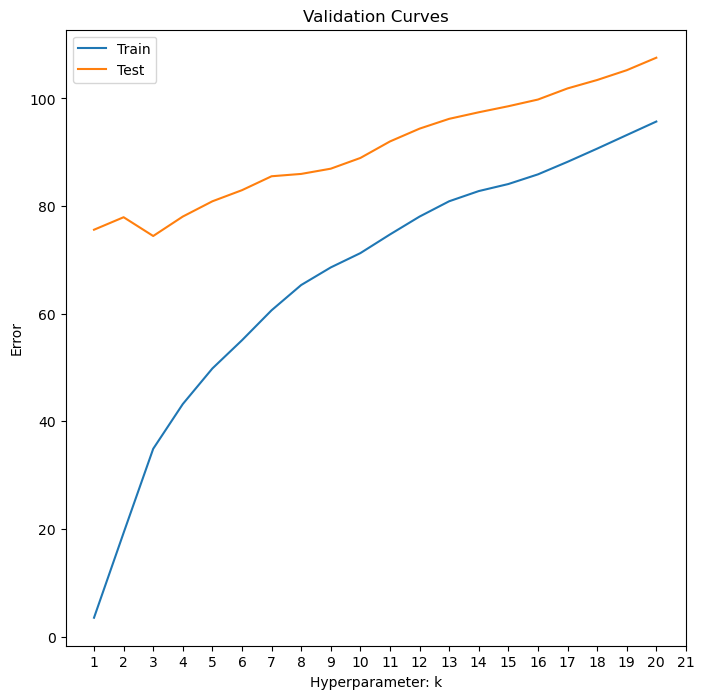

In [34]:
k_values = [i for i in range(1, 21)]


param_results = {}
for k in k_values:
    model_parameters["k"] = k
    results, avg_train_loss, avg_test_loss = k_fold_validation(run_knn, model_parameters, mean_squared_error, folds)
    param_results[k] = {"train": avg_train_loss, "test": avg_test_loss}
    
# plot the validation curves
hyperparameters = list(param_results.keys())
train_errors = [value["train"] for value in param_results.values()]
test_errors = [value["test"] for value in param_results.values()]

plt.rcParams["figure.figsize"] = [8, 8]

# plot train and test errors
plt.plot(hyperparameters, train_errors, label='Train')
plt.plot(hyperparameters, test_errors, label='Test')

# set axis ranges
custom_ticks = [i for i in hyperparameters] + [hyperparameters[-1] +1]
plt.xticks(custom_ticks, [val for val in custom_ticks])

# plot labels
plt.xlabel(f"Hyperparameter: k")
plt.ylabel("Error")
plt.title("Validation Curves")
plt.legend()
plt.show()

The performance when k is equal to 3 in the validation curves above minimizes the error on the test set. The gap between the training and test errors also started to decrease with a k value of 3. The errors on both the training and test sets increased with every k value beyond 3. 

## Generalization Error

Analyze and discuss the generalization error of the model with the value of k from the previous section.

In [35]:
# The best valuefrom above
model_parameters["k"] = 3

# Use cross-fold validation with 10 folds to evaluate the model
results, avg_train_loss, avg_test_loss = k_fold_validation(run_knn, model_parameters, mean_squared_error, folds)

# print results
print("-----All Folds-----\n")
for index, fold in enumerate(results):
    print(f"Fold {index+1} Training Loss (MSE): {round(fold['train_loss'], 2)}, Test Loss (MSE): {round(fold['test_loss'], 2)}")

print(f"\nModel: Average Training loss (MSE): {round(avg_train_loss, 2)}, Average Test Loss (MSE): {round(avg_test_loss, 2)}")
print(f"\nRelative Squared Error (RSE): Train: {round(avg_train_loss/base_avg_train_loss, 2)}, Test: {round(avg_test_loss/base_avg_test_loss, 2)}")

-----All Folds-----

Fold 1 Training Loss (MSE): 36.27, Test Loss (MSE): 78.51
Fold 2 Training Loss (MSE): 33.77, Test Loss (MSE): 102.94
Fold 3 Training Loss (MSE): 35.18, Test Loss (MSE): 53.83
Fold 4 Training Loss (MSE): 33.37, Test Loss (MSE): 101.67
Fold 5 Training Loss (MSE): 36.52, Test Loss (MSE): 65.12
Fold 6 Training Loss (MSE): 36.62, Test Loss (MSE): 64.01
Fold 7 Training Loss (MSE): 35.38, Test Loss (MSE): 57.54
Fold 8 Training Loss (MSE): 33.44, Test Loss (MSE): 64.0
Fold 9 Training Loss (MSE): 33.96, Test Loss (MSE): 90.9
Fold 10 Training Loss (MSE): 34.53, Test Loss (MSE): 65.86

Model: Average Training loss (MSE): 34.9, Average Test Loss (MSE): 74.44

Relative Squared Error (RSE): Train: 0.03, Test: 0.05


The generalization error describes how well the model will perform on future data. Therefore, the generalization error analyzes the model's performance on unseen data using the test set. The problem above identified that an MSE of 70 could yield a relative accuracy of around 95%. The error on the test set is close to reaching the acceptance criteria selected above, and the MSE of around 75% also produced a relative accuracy of 95%. The comparison of the training MSE to the test MSE shows that the model is overfitting to the training data and might not perform well on test sets that are not representative of the training set. 

## Test with Data Normalization 

Implement mean normalization (also called "z-score standardization") of the *features* and reevaluate the model.

In [36]:
# normalize the data
new_folds = []
for fold in folds:
    data_values, labels = split_labels(fold, model_parameters["label_index"])
    norm_data = normalize_data(data_values, standardize)

    # add the y-values back to the data frame
    for index, row in enumerate(norm_data):
        row.append(labels[index])
    new_folds.append(norm_data)

In [37]:
results, avg_train_loss, avg_test_loss = k_fold_validation(run_knn, model_parameters, mean_squared_error, new_folds)

# print results
print("-----All Folds-----\n")
for index, fold in enumerate(results):
    print(f"Fold {index+1} Training Loss (MSE): {round(fold['train_loss'], 2)}, Test Loss (MSE): {round(fold['test_loss'], 2)}")
    
print(f"\nModel: Average Training loss (MSE): {round(avg_train_loss, 2)}, Average Test Loss (MSE): {round(avg_test_loss, 2)}")
print(f"\nRelative Squared Error (RSE): Train: {round(avg_train_loss/base_avg_train_loss, 2)}, Test: {round(avg_test_loss/base_avg_test_loss, 2)}")

-----All Folds-----

Fold 1 Training Loss (MSE): 37.02, Test Loss (MSE): 50.5
Fold 2 Training Loss (MSE): 35.15, Test Loss (MSE): 108.29
Fold 3 Training Loss (MSE): 38.86, Test Loss (MSE): 66.29
Fold 4 Training Loss (MSE): 35.87, Test Loss (MSE): 113.04
Fold 5 Training Loss (MSE): 38.59, Test Loss (MSE): 56.3
Fold 6 Training Loss (MSE): 37.39, Test Loss (MSE): 88.4
Fold 7 Training Loss (MSE): 37.57, Test Loss (MSE): 72.52
Fold 8 Training Loss (MSE): 36.68, Test Loss (MSE): 72.06
Fold 9 Training Loss (MSE): 36.38, Test Loss (MSE): 101.83
Fold 10 Training Loss (MSE): 34.76, Test Loss (MSE): 72.98

Model: Average Training loss (MSE): 36.83, Average Test Loss (MSE): 80.22

Relative Squared Error (RSE): Train: 0.03, Test: 0.06


Applying z-score standardization to the dataset slightly reduced the model's performance. Z-score standardization assumes that the data follows a normal distribution. If the features are not normally distributed, z-score standardization could hurt performance. The histograms below describe the distributions of the features. This performance decrease could indicate that important characteristics of the features are lost in standardization. 

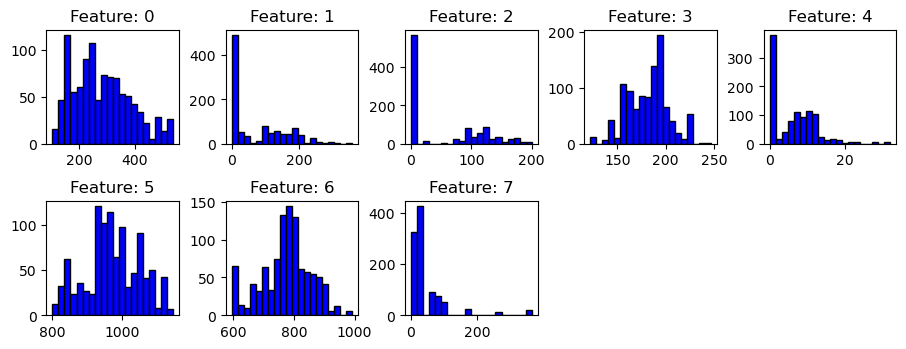

In [38]:
feature_0 = [row[0] for row in data]
feature_1 = [row[1] for row in data]
feature_2 = [row[2] for row in data]
feature_3 = [row[3] for row in data]
feature_4 = [row[4] for row in data]
feature_5 = [row[5] for row in data]
feature_6 = [row[6] for row in data]
feature_7 = [row[7] for row in data]

plt.rcParams["figure.figsize"] = [10, 10]

# Set the starting index for the 2 X 5 plot of images
starting_fig_index = 0
features = [feature_0, feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7]
for index, feature in enumerate(features):
    starting_fig_index += 1
    plt.subplot(5, 5, starting_fig_index)
    plt.hist(feature, bins=20, color='blue', edgecolor='black')
    plt.title(f"Feature: {index}")
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.10, right=0.95, hspace=0.5, wspace=0.35) 
plt.show()

The histograms show that features 1, 2, 4, and 7 are not normally distributed. These distributions could explain why z-score standardization did not increase model performance. Another approach to data normalization is min/max normalization. However, min/max normalization is sensitive to outliers and would not work well for this dataset without the outliers removed. 